# MyND Offline Processing
Author: Geeling Chau<br> 
Description: Process xdf files recorded from experimental sessions to determine file eligibility and data feature extraction.<br>
Sources: 
- Ollie's Segment Speller Offline Processing Code https://github.com/ollie-d/SegSpeller/blob/master/Offline%20Processing.ipynb 
- neurodsp https://github.com/neurodsp-tools/neurodsp


## Imports

In [1]:
import sys, pathlib
sys.path.insert(0, str(pathlib.Path().absolute().parent))

from helper_scripts.helperFunctions import *
from helper_scripts.constants import *
from helper_scripts.dataAnalysisFunctions import *

import scipy.io

In [2]:
# For Legacy
MARKER_STREAM_TYPE = 'markers'
EEG_STREAM_TYPE = 'eeg'
AUX_STREAM_TYPE = 'aux'
EYE_STREAM_TYPE = 'eye'
EYE_NORM_STREAM_TYPE = 'eyenorm'
DATA_STREAM_TYPE = 'data'
TIME_STREAM_TYPE = 'time'
FS_STREAM_TYPE = 'fs'


## Main

### Get Data

In [4]:
'''
# Files that work with this notebook: 
P004/participant_P004_exp001_block_full_start.xdf # full start
P004/participant_P004_exp002_block_full_start.xdf # This should work: after restarting computer
P004/participant_P004_exp003_block_full_start.xdf # This should work too
P004/participant_P004_exp001_block_full_short.xdf # Works (no instructions section tho)
P004/participant_P004_exp001_block_full_long.xdf # Works (no instructions section tho)

P001/participant_P001_exp001_block_full_long.xdf # Me, very sleepy. 
P001/participant_P001_exp001_block_long.xdf 
P001/participant_P001_exp001_block_short.xdf # Meme shown markers are wonky 
P001/participant_P001_exp001_block_start.xdf # before changing the point system on the "m" press
P001/participant_P001_exp001_block_test_markers.xdf # Meme shown markers should be fixed

P005/participant_P005_exp001_block_start.xdf # 
P005/participant_P005_exp001_block_short.xdf # 
P005/participant_P005_exp001_block_long.xdf # Full set with new markers and point system

P001/exp002_block_start.xdf 
P001/exp002_block_short.xdf 
P001/exp002_block_long.xdf # Me, very sleepy again... Midnight. 

# K
P006/part_P006_exp001_block_long.xdf
P006/part_P006_exp001_block_short.xdf

# A 
P007/part_P007_exp001_block_short.xdf
P007/part_P007_exp001_block_short2.xdf

# P
P008/expP008_block_start.xdf
P008/expP008_block_short.xdf
P008/expP008_block_long.xdf # Section 2 has incorrect responses

P001/part_P001_block_S004.xdf
P001/part_P001_block_S005.xdf
P001/part_P001_block_S006.xdf


'''
foldername="P001"
filename="part_P001_block_S006"
XDF_Path = "../data/XDF_data/"+foldername+"/"+filename+".xdf"
XDF_Data = loadxdf(XDF_Path)
if StreamType.EEG.value in XDF_Data : 
    eeg_fs = getEEGfs(XDF_Data) # int(XDF_Data[StreamType.EEG.value][StreamType.FS.value])
    print("eeg_fs = ", eeg_fs)
if StreamType.EYE.value in XDF_Data : 
    eye_fs = getEYEfs(XDF_Data) # int(mean_fs_eye_tracker)
    print("eye_fs = ", eye_fs)
    
# Trim the data to only include the time PsychoPy was running
XDF_Data = epochByMarkIndex(0, -1, XDF_Data)

# Baseline EEG data to reduce session to session and channel to channel DC offsets
# Subtract mean of EEG data from the full data stream
for channel in channels: 
    baselined_eeg = XDF_Data[StreamType.EEG.value][StreamType.DATA.value][:,channels[channel]] - np.mean(XDF_Data[StreamType.EEG.value][StreamType.DATA.value][:,channels[channel]])
    XDF_Data[StreamType.EEG.value][StreamType.DATA.value][:,channels[channel]] = baselined_eeg
    

eeg_fs =  250


In [5]:
# Incorporate and save matlab filtered data if needed
incorporate_matlab_data = False

if incorporate_matlab_data:
    matlab_eeg_path = "../data/"+foldername+"/"+filename+".mat"
    matlab_eeg_variable_name = "eeg_data"
    mat_eeg = scipy.io.loadmat(matlab_eeg_path, uint16_codec='ascii')
    filtered_matlab_data = copy.deepcopy(XDF_Data)
    for channel in channels :
        sig_filt = mat_eeg[matlab_eeg_variable_name][channels[channel],:]
        filtered_matlab_data[StreamType.EEG.value][StreamType.DATA.value][:,channels[channel]] = sig_filt
    
    # Trim the data to only include the time PsychoPy was running
    filtered_matlab_data = epochByMarkIndex(0, -1, filtered_matlab_data)
    print(len(filtered_matlab_data[StreamType.EEG.value][StreamType.DATA.value][:,0]))

In [6]:
len(XDF_Data[StreamType.EEG.value][StreamType.DATA.value][:,0])

211610

### Check Markers

In [7]:
# Check Marker existance
marker_indexes = getMarkerIndexes(XDF_Data)
markersFound = True
for marker_key in PSYCHO_PY_MARKERS : 
    if PSYCHO_PY_MARKERS[marker_key] not in marker_indexes.keys(): 
        markersFound = False 
        print("Missing Marker:", PSYCHO_PY_MARKERS[marker_key])
print("All Markers Found?", markersFound)

Missing Marker: --InstructionStart
Missing Marker: --InstructionStop
Missing Marker: --MemeShown
Missing Marker: --MemeHidden
Missing Marker: --NewMeme
All Markers Found? False


### Check / Visualize timestamps

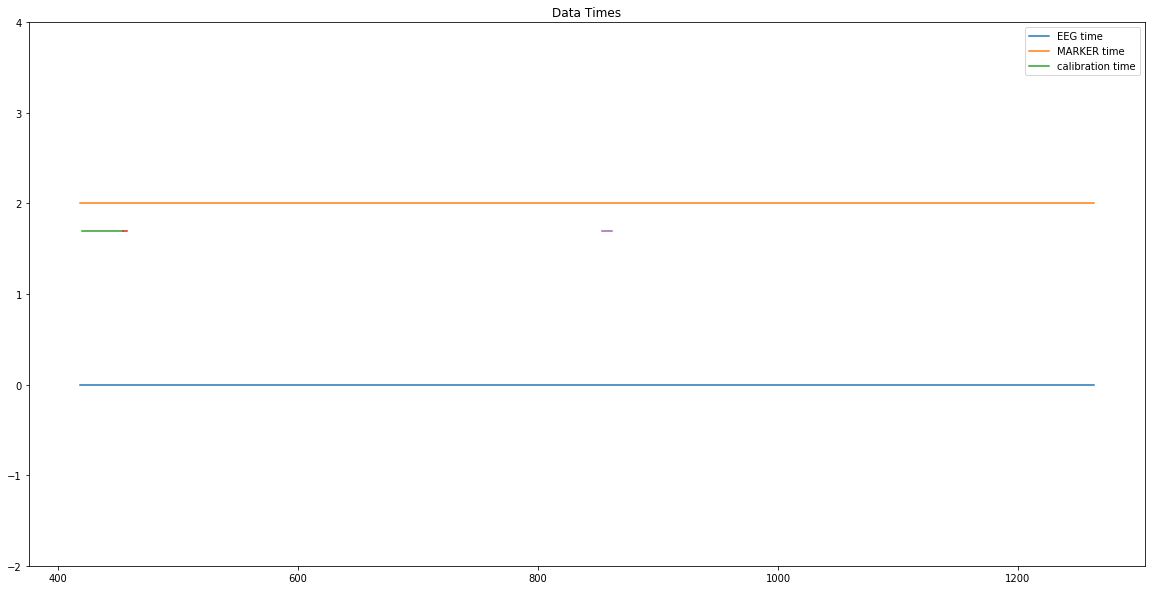

EEG, EYE, and MARKER should all have the same time length
Small specks are Memorization times


In [8]:
start_times = {}
end_times = {}

plt.figure(figsize=(20,10))

if StreamType.EEG.value in XDF_Data : 
    start_times[StreamType.EEG.value] = XDF_Data[StreamType.EEG.value][StreamType.TIME.value][0]
    end_times[EEG_STREAM_TYPE] = XDF_Data[EEG_STREAM_TYPE][TIME_STREAM_TYPE][-1]

if StreamType.EYE.value in XDF_Data : 
    start_times[StreamType.EYE.value] = XDF_Data[StreamType.EYE.value][StreamType.TIME.value][0]
    end_times[StreamType.EYE.value] = XDF_Data[StreamType.EYE.value][StreamType.TIME.value][-1]

start_times[StreamType.MARKER.value] = XDF_Data[StreamType.MARKER.value][StreamType.TIME.value][0]
end_times[StreamType.MARKER.value] = XDF_Data[StreamType.MARKER.value][StreamType.TIME.value][-1]

start_times["Calibration"] = XDF_Data[StreamType.MARKER.value][StreamType.TIME.value][marker_indexes[PSYCHO_PY_MARKERS["calibrationStart"]]]
end_times["Calibration"] = XDF_Data[StreamType.MARKER.value][StreamType.TIME.value][marker_indexes[PSYCHO_PY_MARKERS["calibrationStop"]]]

start_times["Memorization"] = XDF_Data[StreamType.MARKER.value][StreamType.TIME.value][marker_indexes[PSYCHO_PY_MARKERS["memorizationStart"]]]
end_times["Memorization"] = XDF_Data[StreamType.MARKER.value][StreamType.TIME.value][marker_indexes[PSYCHO_PY_MARKERS["memorizationStop"]]]

if PSYCHO_PY_MARKERS["instructionStart"] in marker_indexes.keys():
    start_times["Instruction"] = XDF_Data[MARKER_STREAM_TYPE][StreamType.TIME.value][marker_indexes[PSYCHO_PY_MARKERS["instructionStart"]]]
    end_times["Instruction"] = XDF_Data[MARKER_STREAM_TYPE][StreamType.TIME.value][marker_indexes[PSYCHO_PY_MARKERS["instructionStop"]]]

if StreamType.EEG.value in XDF_Data : 
    plt.plot([start_times[EEG_STREAM_TYPE], end_times[EEG_STREAM_TYPE]], [0,0], label="EEG time")
if StreamType.EYE.value in XDF_Data : 
    plt.plot([start_times[StreamType.EYE.value], end_times[StreamType.EYE.value]], [1,1], label="EYE time")
plt.plot([start_times[StreamType.MARKER.value], end_times[StreamType.MARKER.value]], [2,2], label="MARKER time")
plt.plot([start_times["Calibration"], end_times["Calibration"]], [1.7,1.7], label="calibration time")
plt.plot([start_times["Memorization"], end_times["Memorization"]], [1.7,1.7])

if PSYCHO_PY_MARKERS["instructionStart"] in marker_indexes.keys():
    plt.plot([start_times["Instruction"], end_times["Instruction"]], [1.8,1.8], label="instruction time")


plt.ylim((-2, 4))
plt.title("Data Times")
plt.legend()
plt.show()

print("EEG, EYE, and MARKER should all have the same time length")
print("Small specks are Memorization times")


In [9]:
len(start_times["Memorization"])

2

### Check Sampling for Eye

In [10]:
# Sanity Checks for Eye Sampling
time_differences_eye_tracker = [XDF_Data[StreamType.EYE.value][StreamType.TIME.value][i+1]-XDF_Data[StreamType.EYE.value][StreamType.TIME.value][i] for i in range(len(XDF_Data[StreamType.EYE.value][StreamType.TIME.value])-1)]
mean_fs_eye_tracker = 1/np.mean(time_differences_eye_tracker)
std_fs_eye_tracker = np.std(time_differences_eye_tracker)
num_samples_eye_tracker = len(XDF_Data[StreamType.EYE.value][StreamType.TIME.value])

print("Max time difference of eye tracker:\t\t\t\t", max(time_differences_eye_tracker))
print("Min time difference of eye tracker:\t\t\t\t", min(time_differences_eye_tracker))
print("Avg time difference of eye tracker:\t\t\t\t", np.mean(time_differences_eye_tracker))

print("Mean eye sampling frequency (should be 30-50Hz):\t\t", mean_fs_eye_tracker)
print("Number of eye samples (should be >7000 for a full 5 min run):\t", num_samples_eye_tracker)


# Visualize EEG recording gaps
plt.plot(list(range(len(time_differences_eye_tracker))), time_differences_eye_tracker)
plt.title("Time differences for Eye tracker")
plt.xlabel("ith time difference")
plt.ylabel("time difference value (s)")
plt.show()

# Inspect largest eye data pause: 
len_range = 50
index_of_max_time_differences_eye_tracker = time_differences_eye_tracker.index(max(time_differences_eye_tracker))
# print("Time differences around Max diff:", time_differences_eeg[index_of_max_time_differences_eeg-len_range:index_of_max_time_differences_eeg+25])


new_data = epochByTime(XDF_Data[StreamType.EYE.value][StreamType.TIME.value][index_of_max_time_differences_eye_tracker - len_range], XDF_Data[StreamType.EYE.value][StreamType.TIME.value][index_of_max_time_differences_eye_tracker + len_range], XDF_Data)
print("Markers around largest time difference:", new_data[StreamType.MARKER.value][StreamType.DATA.value])

plt.plot(np.array(list(range(len(time_differences_eye_tracker[index_of_max_time_differences_eye_tracker-len_range:index_of_max_time_differences_eye_tracker+len_range])))) - len_range, time_differences_eye_tracker[index_of_max_time_differences_eye_tracker-len_range:index_of_max_time_differences_eye_tracker+len_range])
plt.title("+/-" + str(len_range)+ " time differences around max diff index")
plt.ylabel("time difference value (s)")


plt.show()

KeyError: 'eye'

## Check Sampling for EEG

Max time difference of eeg (0.15 - 0.5 is reasonable):	 0.012624290810094863
Min time difference of eeg (0.0001 is reasonable):	 0.00017814899740642431
Avg time difference of eeg (should be ~0.004):		 0.003995866530227502
Mean eye sampling frequency (should be 250Hz):		 250.2586090990045
Number of eeg samples (should be 75,000 for a full 5 min run):	 211610


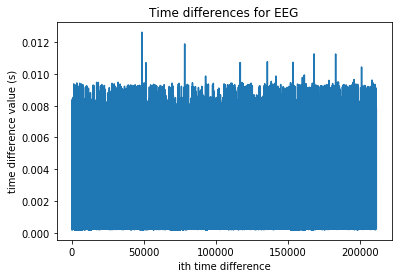

Markers around largest time difference (--PsychopyStart is reasonable): [['--Blank']]


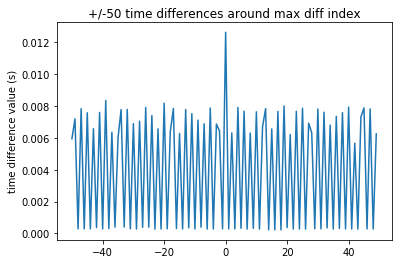

In [11]:
# Check EEG data times

time_differences_eeg = [XDF_Data[EEG_STREAM_TYPE][TIME_STREAM_TYPE][i+1]-XDF_Data[EEG_STREAM_TYPE][TIME_STREAM_TYPE][i] for i in range(len(XDF_Data[EEG_STREAM_TYPE][TIME_STREAM_TYPE])-1)]
mean_fs_eeg = 1/np.mean(time_differences_eeg)
num_samples_eeg = len(XDF_Data[EEG_STREAM_TYPE][TIME_STREAM_TYPE])


print("Max time difference of eeg (0.15 - 0.5 is reasonable):\t", max(time_differences_eeg))
print("Min time difference of eeg (0.0001 is reasonable):\t", min(time_differences_eeg))
print("Avg time difference of eeg (should be ~0.004):\t\t", np.mean(time_differences_eeg))


print("Mean eye sampling frequency (should be 250Hz):\t\t", mean_fs_eeg)
print("Number of eeg samples (should be 75,000 for a full 5 min run):\t", num_samples_eeg)

# Visualize EEG recording gaps
plt.plot(list(range(len(time_differences_eeg))), time_differences_eeg)
plt.title("Time differences for EEG")
plt.xlabel("ith time difference")
plt.ylabel("time difference value (s)")
plt.show()

# Inspect largest EEG data pause: 
len_range = 50
index_of_max_time_differences_eeg = time_differences_eeg.index(max(time_differences_eeg))
# print("Time differences around Max diff:", time_differences_eeg[index_of_max_time_differences_eeg-len_range:index_of_max_time_differences_eeg+25])


new_data = epochByTime(XDF_Data[StreamType.EEG.value][StreamType.TIME.value][index_of_max_time_differences_eeg - len_range], XDF_Data[EEG_STREAM_TYPE][TIME_STREAM_TYPE][index_of_max_time_differences_eeg + len_range], XDF_Data)
print("Markers around largest time difference (--PsychopyStart is reasonable):", new_data[StreamType.MARKER.value][StreamType.DATA.value])

plt.plot(np.array(list(range(len(time_differences_eeg[index_of_max_time_differences_eeg-len_range:index_of_max_time_differences_eeg+len_range])))) - len_range, time_differences_eeg[index_of_max_time_differences_eeg-len_range:index_of_max_time_differences_eeg+len_range])
plt.title("+/-" + str(len_range)+ " time differences around max diff index")
plt.ylabel("time difference value (s)")


plt.show()

### Check EEG channels

In [12]:
# One timepoint of EEG data [VEOG, HEOG, 0, 0, 0, 0, FP2 (right), FP1 (left)]
XDF_Data[StreamType.EEG.value][StreamType.DATA.value][1200]

array([-3.4515093e+03, -3.8942329e+03,  1.5625000e-02,  1.5625000e-02,
        1.5625000e-02,  1.5625000e-02, -3.6364727e+03, -3.7933416e+03],
      dtype=float32)

### EEG Filtering and Frequency Check

In [13]:
# Check All Data
filtered_data = filterStreamStructEEG(XDF_Data)
channel = channels['right_eeg']
right_eeg_data = XDF_Data[StreamType.EEG.value][StreamType.DATA.value][:,channel]
right_sig_filt = filtered_data[StreamType.EEG.value][StreamType.DATA.value][:,channel]

channel = channels['left_eeg']

left_eeg_data = XDF_Data[StreamType.EEG.value][StreamType.DATA.value][:,channel]
left_sig_filt = filtered_data[StreamType.EEG.value][StreamType.DATA.value][:,channel]

/Users/glchau/anaconda3/envs/mne/lib/python3.6/site-packages/neurodsp/filt/filter.py:86: UserWarning: Edge artifacts are not removed when using an IIR filter.
  warn('Edge artifacts are not removed when using an IIR filter.')
/Users/glchau/anaconda3/envs/mne/lib/python3.6/site-packages/neurodsp/filt/iir.py:136: UserWarning: IIR filters are not recommended other than for notch filters.
  warn('IIR filters are not recommended other than for notch filters.')
/Users/glchau/anaconda3/envs/mne/lib/python3.6/site-packages/neurodsp/filt/utils.py:65: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))
/Users/glchau/anaconda3/envs/mne/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 

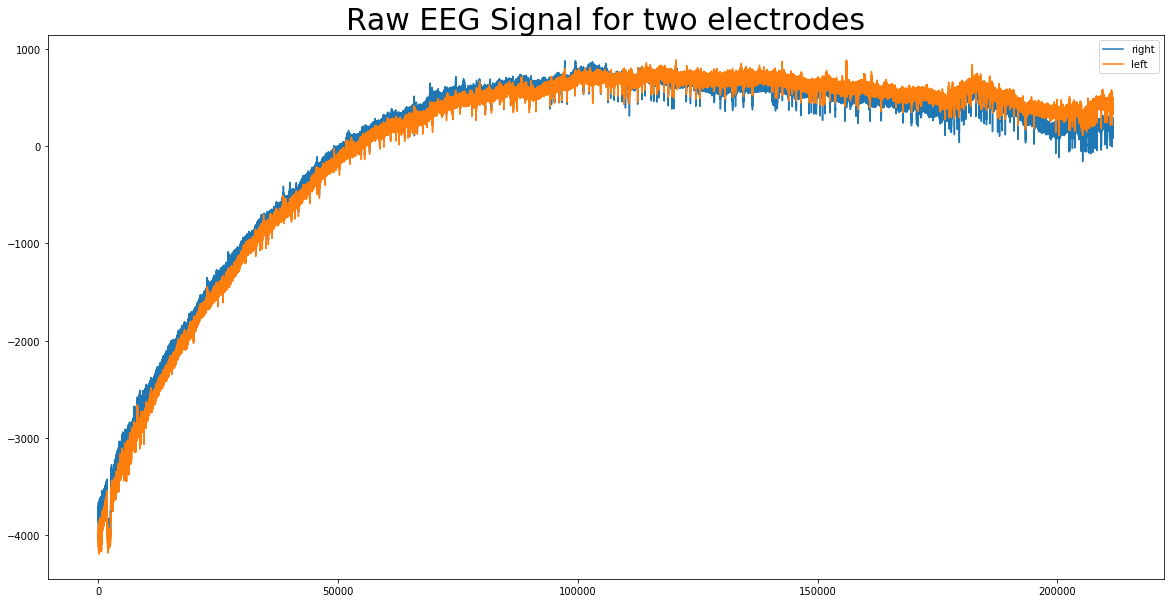

voltage range should be roughly [-1000, 1000]


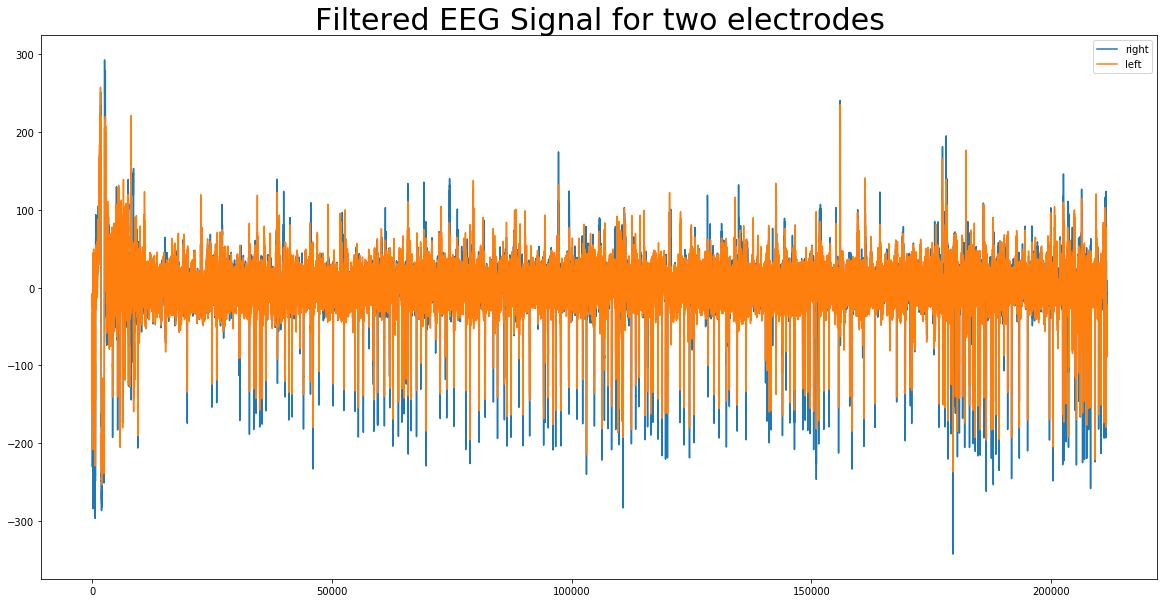

voltage amplitude should be roughly [-100, 100]


In [14]:
plt.figure(figsize=(20,10))
plt.plot(right_eeg_data, label="right")
plt.plot(left_eeg_data, label="left")

plt.title("Raw EEG Signal for two electrodes", size=30)
plt.legend()
plt.show()
print("voltage range should be roughly [-1000, 1000]")

plt.figure(figsize=(20,10))

plt.plot(right_sig_filt, label="right")
plt.plot(left_sig_filt, label="left")
plt.title("Filtered EEG Signal for two electrodes", size=30)
plt.legend()
plt.show()
print("voltage amplitude should be roughly [-100, 100]")


In [15]:
print("right filtered mean", np.mean(right_sig_filt))
print("left filtererd mean", np.mean(left_sig_filt))


right filtered mean -0.116248325
left filtererd mean -0.052879725


In [16]:
np.mean(right_sig_filt - np.mean(right_sig_filt))

6.922375e-08

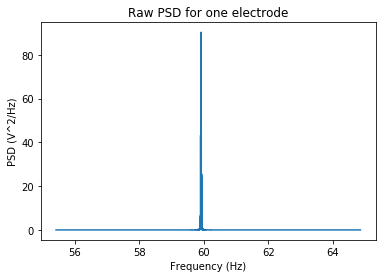

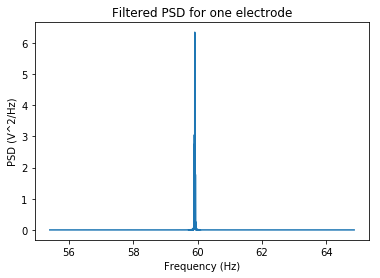

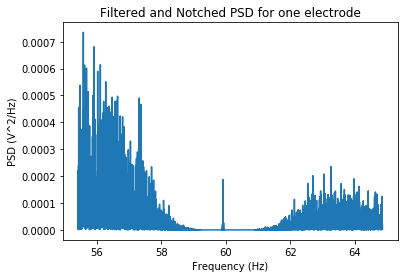

In [17]:
# See the 60Hz data
right_margin =  2000 # Data points to go past 60/61 Hz
left_margin = 6000 # Num data points to go before 60/61 Hz


freq, psd = signal.periodogram(right_eeg_data, fs=int(eeg_fs), scaling='spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.title('Raw PSD for one electrode')
plt.plot(freq[len(freq) // 2 - left_margin: len(freq) // 2 + right_margin], psd[len(freq) // 2 - left_margin: len(freq) // 2 + right_margin])
plt.show()

# Filter with band pass
#sig_filt = filterEEG(right_eeg_data, eeg_fs, f_range=(1, 50))
sig_filt = filt.filter_signal(right_eeg_data, eeg_fs, 'bandpass', f_range, filter_type='iir', butterworth_order=2)
freq, psd = signal.periodogram(sig_filt, fs=int(eeg_fs), scaling='spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)') 
plt.title('Filtered PSD for one electrode')
plt.plot(freq[len(freq) // 2 - left_margin: len(freq) // 2 + right_margin], psd[len(freq) // 2 - left_margin: len(freq) // 2 + right_margin])
plt.show()

# Filter with 60 Hz notch
test_sig_filt = filt.filter_signal(sig_filt, eeg_fs, 'bandstop', (58, 62), n_seconds=1)
num_nans = sum(np.isnan(test_sig_filt))
sig_filt = np.concatenate(([0]*num_nans, sig_filt, [0]*num_nans))
sig_filt = filt.filter_signal(sig_filt, int(eeg_fs), 'bandstop', (58, 62), n_seconds=1)
sig_filt = sig_filt[~np.isnan(sig_filt)]

freq, psd = signal.periodogram(sig_filt, fs=int(eeg_fs), scaling='spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)') 
plt.title('Filtered and Notched PSD for one electrode')
plt.plot(freq[len(freq) // 2 - left_margin: len(freq) // 2 + right_margin], psd[len(freq) // 2 - left_margin: len(freq) // 2 + right_margin])
plt.show()


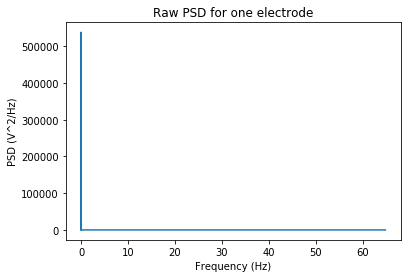

In [18]:
freq, psd = signal.periodogram(right_eeg_data, fs=int(eeg_fs), scaling='spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.title('Raw PSD for one electrode')
plt.plot(freq[: len(freq) // 2 + right_margin], psd[: len(freq) // 2 + right_margin])
plt.show()

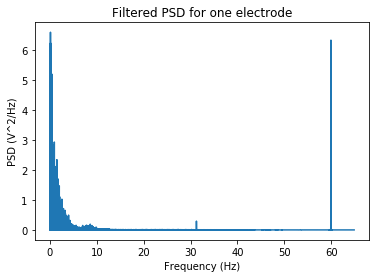

In [19]:
sig_filt = filt.filter_signal(right_eeg_data, eeg_fs, 'bandpass', f_range, filter_type='iir', butterworth_order=2)
freq, psd = signal.periodogram(sig_filt, fs=int(eeg_fs), scaling='spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)') 
plt.title('Filtered PSD for one electrode')
plt.plot(freq[: len(freq) // 2 + right_margin], psd[: len(freq) // 2 + right_margin])
plt.show()

In [20]:
f_range

(0.1, 50)

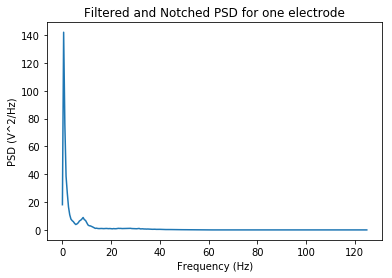

In [21]:
# All filters together: 
sig_filt = filterEEG(right_eeg_data, eeg_fs, f_range=(0.1, 50))
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)') 
plt.title('Filtered and Notched PSD for one electrode')
freqs, psds, psd_avg = getFreqsAndPSD([sig_filt])
plt.plot(freqs[: len(freqs) // 2 + right_margin], psds[0][: len(freqs) // 2 + right_margin])
plt.show()

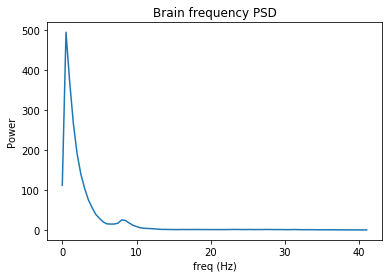

In [22]:
# See the 1-40hz data
freq_mean, psd_mean = spectral.compute_spectrum(sig_filt, eeg_fs, method='welch', avg_type='mean', nperseg=eeg_fs*2)
plt.title("Brain frequency PSD")
plt.xlabel("freq (Hz)")
plt.ylabel("Power")
plt.plot(freq_mean[:len(freq_mean)//3], psd_mean[:len(freq_mean)//3])
plt.show()

### Check Eye Data noise

In [23]:
# Check eye data

eye_x_data=filtered_data[StreamType.EYENORM.value][StreamType.DATA.value][:,0]
eye_y_data=filtered_data[StreamType.EYENORM.value][StreamType.DATA.value][:,1]
eye_time_data=filtered_data[StreamType.EYENORM.value][StreamType.TIME.value]

calibration_data = getSectionData("calibration", filtered_data)

numSections = getNumSections(XDF_Data)
article_sections = list()
for i in range(numSections) : 
    article_sections.append(getArticleSectionData("response", i, filtered_data))
eye_x_data_calibration=calibration_data[StreamType.EYENORM.value][StreamType.DATA.value][:,0]
eye_y_data_calibration=calibration_data[StreamType.EYENORM.value][StreamType.DATA.value][:,1]
eye_time_data_calibration=calibration_data[StreamType.EYENORM.value][StreamType.TIME.value]


N = 5
smoothed_eye_x_data = np.convolve(eye_x_data, np.ones((N,))/N, mode='valid')
smoothed_eye_y_data = np.convolve(eye_y_data, np.ones((N,))/N, mode='valid')
smoothed_eye_x_calibration_data = np.convolve(eye_x_data_calibration, np.ones((N,))/N, mode='valid')

f_hi = 2
filtered_eye_x_data = filterEYE(eye_x_data, fs=eye_fs, f_hi=2)
filtered_eye_y_data = filterEYE(eye_y_data, fs=eye_fs, f_hi=2)
filtered_eye_x_calibration_data = filterEYE(eye_x_data_calibration, fs=eye_fs, f_hi=2)


plt.plot(eye_time_data, eye_x_data, label="raw x data")
plt.plot(eye_time_data_calibration, eye_x_data_calibration, label="raw x cal data")
for i in range(numSections) : 
    plt.plot(article_sections[i][StreamType.EYENORM.value][StreamType.TIME.value], article_sections[i][StreamType.EYENORM.value][StreamType.DATA.value][:,0], label="section " + str(i))
    
plt.legend()
plt.title("raw eye x data")
plt.show()

plt.plot(eye_time_data[N-1:], smoothed_eye_x_data, label="smooth x data")
plt.plot(eye_time_data_calibration[N-1:], smoothed_eye_x_calibration_data, label="smoothed x cal data")
plt.title("smooth eye x data")
plt.legend()
plt.show()

plt.plot(eye_time_data, filtered_eye_x_data, label="filtered x data")
plt.plot(eye_time_data_calibration, filtered_eye_x_calibration_data, label="filtered x cal data")
plt.title("filtered eye x data")
plt.legend()
plt.show()


KeyError: 'eyenorm'

In [24]:
filtered_eye_x_data = filterEYE(eye_x_data, fs=eye_fs, f_hi=2)
plt.plot(eye_time_data, eye_x_data, label="raw x data")
plt.plot(eye_time_data, filtered_eye_x_data, label="filtered x data")
plt.legend()


NameError: name 'eye_x_data' is not defined

### Get Eye Direction Calibration data

KeyError: 'eyenorm'

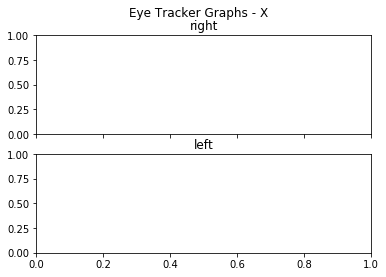

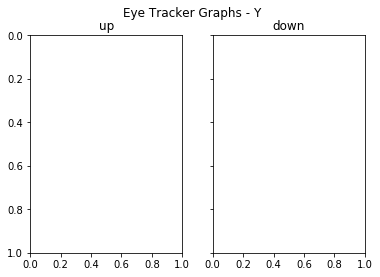

In [25]:
# Calibration processing of eye blinks and summary sanity checks
calibrated_x = {}
calibrated_y = {}

fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.set_title("right")
ax2.set_title("left")
fig.suptitle("Eye Tracker Graphs - X")

fig2, (ay1, ay2) = plt.subplots(1, 2, sharey=True)
ay1.set_title("up")
ay2.set_title("down")
ay1.invert_yaxis() 
fig2.suptitle("Eye Tracker Graphs - Y")


# Smoothing for eye data (cut off frequency)
f_hi = 2

for x_dir in PSYCHOPY_DIRECTIONS_X.keys():
    for y_dir in PSYCHOPY_DIRECTIONS_Y.keys(): 
        location = "("+str(PSYCHOPY_DIRECTIONS_X[x_dir])+", "+str(PSYCHOPY_DIRECTIONS_Y[y_dir])+")"
        ith = 0 if not location == "(0, 0)" else -3 # Get the third to last value if we are looking for the center location. This corresponds to the last (0,0) value in the calibration phase.

        new_data = epochByMarkIndex(marker_indexes[location][ith] - 2, marker_indexes[location][ith], XDF_Data)
        x = new_data[EYE_NORM_STREAM_TYPE]['data'][:,0]
        x = filterEYE(x, eye_fs, f_hi=f_hi)
        new_data[EYE_NORM_STREAM_TYPE]['data'][:,0] = x
        y = new_data[EYE_NORM_STREAM_TYPE]['data'][:,1]
        y = filterEYE(y, eye_fs, f_hi=f_hi)
        new_data[EYE_NORM_STREAM_TYPE]['data'][:,1] = y
        time = new_data[EYE_NORM_STREAM_TYPE]['time']
        timepoints=range(len(time))
        if(x_dir == 'right') :
            ax1.plot(x, timepoints, color="orange")
        if(x_dir == 'left') :
            ax2.plot(x, timepoints, color="orange")
        
        if(y_dir == 'up') :
            ay1.plot(timepoints, y, color="orange")
        if(y_dir == 'down') :
            ay2.plot(timepoints, y, color="orange")
        
        # Get only the last 1/3 of time data from x
        time_range = time[-1] - time[0]
        time_range = time_range*2 / 3
        start_time = time[0] + time_range
        end_time = time[-1]
        
        third_data = epochByTime(start_time, end_time, new_data)
        x = third_data[EYE_NORM_STREAM_TYPE]['data'][:,0]
        y = third_data[EYE_NORM_STREAM_TYPE]['data'][:,1]
        time_third = third_data[EYE_NORM_STREAM_TYPE]['time']
        timepoints = np.array(list(range(len(time_third)))) + len(time) - len(time_third)
        if(x_dir == 'right') :
            ax1.plot(x, timepoints, color="blue")
        if(x_dir == 'left') :
            ax2.plot(x, timepoints, color="blue")
            
        if(y_dir == 'up') :
            ay1.plot(timepoints, y, color="blue")
        if(y_dir == 'down') :
            ay2.plot(timepoints, y, color="blue")
        
        
        # Append new average to calibration matricies
        avg_x = np.mean(x)
        avg_y = np.mean(y)
        
        if x_dir not in calibrated_x: 
            calibrated_x[x_dir] = list()
        if y_dir not in calibrated_y: 
            calibrated_y[y_dir] = list()
        calibrated_x[x_dir].append(avg_x)
        calibrated_y[y_dir].append(avg_y)
    
plt.show()

# Average the eye locations
avg_calibrated_x = {}
avg_calibrated_y = {}
for x_dir in calibrated_x: 
    avg_calibrated_x[x_dir] = np.mean(calibrated_x[x_dir])
for y_dir in calibrated_y:
    avg_calibrated_y[y_dir] = np.mean(calibrated_y[y_dir])
    
# Plot the eye averages
for x_dir in avg_calibrated_x: 
    x = avg_calibrated_x[x_dir]
    y = avg_calibrated_y['center']
    plt.scatter([x], [y], label=x_dir)
    plt.annotate(
        x_dir,
        xy=(x+0.01, y-0.005))
for y_dir in avg_calibrated_y:
    x = avg_calibrated_x['center']
    y = avg_calibrated_y[y_dir]
    plt.scatter([x], [y], label=y_dir)
    plt.annotate(
        y_dir,
        xy=(x+0.01, y-0.005))
plt.gca().invert_yaxis()
plt.title("Location of eyes");
plt.show()

# Summary 
x_eye_tracker_pass = False
y_eye_tracker_pass = False
if (avg_calibrated_x['center'] - avg_calibrated_x['left'] > 0) and (avg_calibrated_x['right'] - avg_calibrated_x['center'] > 0):
    x_eye_tracker_pass = True

if (avg_calibrated_y['center'] - avg_calibrated_y['up'] > 0) and (avg_calibrated_y['down'] - avg_calibrated_y['center'] > 0):
    y_eye_tracker_pass = True
    
print("x_eye_tracker_pass:", x_eye_tracker_pass)
print("y_eye_tracker_pass:", y_eye_tracker_pass)

### Standard Deviation of eye

In [26]:
# Standard deviation of eye
numEYEPoints=len(filtered_data[StreamType.EYENORM.value][StreamType.DATA.value][:,0])
window_size = eye_fs // 4
stds = list()
x_values = list()
x_during_experiment = list()
time_experiment_start = filtered_data[StreamType.MARKER.value][StreamType.TIME.value][marker_indexes["--MemorizationStart"][0]]
for i in range(window_size, numEYEPoints): 
    stds.append(np.std(filtered_data[StreamType.EYENORM.value][StreamType.DATA.value][i-window_size:i,0]))
    
    mean_x_val = np.mean(filtered_data[StreamType.EYENORM.value][StreamType.DATA.value][i-window_size:i,0])
    x_values.append(mean_x_val)
    current_time = filtered_data[StreamType.EYENORM.value][StreamType.TIME.value][i]
    if current_time > time_experiment_start :
        x_during_experiment.append(mean_x_val)
    else : 
        x_during_experiment.append(0)
    
plt.plot(stds, label="std")
plt.plot(x_values, label="xvals")
plt.plot(x_during_experiment, label="experiment")
plt.legend()
plt.show()

KeyError: 'eyenorm'

In [27]:
# std of looking at center
center_data = getSectionData("openEye", filtered_data)

center_eye_norm_data_x = center_data[StreamType.EYENORM.value][StreamType.DATA.value][:,0][20:]
center_eye_norm_data_y = center_data[StreamType.EYENORM.value][StreamType.DATA.value][:,1][20:]
center_eye_norm_data_time = center_data[StreamType.EYENORM.value][StreamType.TIME.value][20:]

print("center standard deviation of x:", np.std(center_eye_norm_data_x))
print("center standard deviation of y:", np.std(center_eye_norm_data_y))

trial_data, a, b = getLabelBoundSingleLabelData("newWord", "endWord", filtered_data, go_backward=False)
trial_eye_norm_data_xs = list()
trial_eye_norm_data_ys = list()
x_stds = list()
y_stds = list()
for data in trial_data: 
    trial_eye_norm_data_x = data[StreamType.EYENORM.value][StreamType.DATA.value][:,0]
    trial_eye_norm_data_y = data[StreamType.EYENORM.value][StreamType.DATA.value][:,1]
    trial_eye_norm_data_xs.append(trial_eye_norm_data_x)
    trial_eye_norm_data_ys.append(trial_eye_norm_data_y)
    x_stds.append(np.std(trial_eye_norm_data_x))
    y_stds.append(np.std(trial_eye_norm_data_y))
    
print("avg trial standard deviations of x:", np.mean(x_stds))
print("avg trial standard deviations of y:", np.mean(y_stds))


plt.annotate(
    "down",
    xy=(0.01, avg_calibrated_y['down']-0.01))
plt.annotate(
    "up",
    xy=(0.01, avg_calibrated_y['up']+0.01))

plt.plot(center_eye_norm_data_y, label="center stare")
looking_up_threshold = (avg_calibrated_y['down'] - avg_calibrated_y['up']) / 4 + avg_calibrated_y['up']
print("looking up threshold:", looking_up_threshold)
trial_eye_norm_data_ys_max_mean = [trial_eye_norm_data_y if np.any(np.where(looking_up_threshold > np.array(trial_eye_norm_data_y), True, False)) else [0] for trial_eye_norm_data_y in trial_eye_norm_data_ys]
for trial_eye_norm_data_y in trial_eye_norm_data_ys_max_mean: 
    plt.plot(trial_eye_norm_data_y)

plt.ylim(avg_calibrated_y['up'], avg_calibrated_y['down'])


plt.title("Eye tracker norm of y component of staring")
plt.gca().invert_yaxis()
plt.legend()
plt.show()

plt.annotate(
    "right",
    xy=(0.01, avg_calibrated_x['right']-0.05))
plt.annotate(
    "left",
    xy=(0.01, avg_calibrated_x['left']+0.01))


plt.plot(center_eye_norm_data_x, label="center stare")
looking_right_threshold = avg_calibrated_x['right'] - (avg_calibrated_x['right'] - avg_calibrated_x['left']) / 4
print("looking right threshold:", looking_right_threshold)

trial_eye_norm_data_xs_max_mean = [trial_eye_norm_data_x if np.any(np.where(looking_right_threshold < np.array(trial_eye_norm_data_x), True, False)) else [0] for trial_eye_norm_data_x in trial_eye_norm_data_xs]
for trial_eye_norm_data_x in trial_eye_norm_data_xs_max_mean: 
    plt.plot(trial_eye_norm_data_x)



plt.ylim(avg_calibrated_x['left'], avg_calibrated_x['right'])

plt.title("Eye tracker norm of x component of staring")
plt.legend()
plt.show()


KeyError: 'eyenorm'

## Visualize Blink-related Data


In [28]:
# Get data
new_data, a, b = getMarkerBoundSingleMarkerData(blinkText, "--SpacePressed", original_data=filtered_data)
blink_data=new_data[0]

In [29]:
# Check eye tracker
eye_norm_data_x = blink_data[EYE_NORM_STREAM_TYPE]['data'][:,0]
eye_norm_data_y = blink_data[EYE_NORM_STREAM_TYPE]['data'][:,1]
eye_norm_data_time = blink_data[EYE_NORM_STREAM_TYPE]['time']

plt.annotate(
    "start",
    xy=(eye_norm_data_x[0]+0.01, eye_norm_data_y[0] + 0.005))
plt.annotate(
    "stop",
    xy=(eye_norm_data_x[-1]+0.01, eye_norm_data_y[-1] + 0.005))
plt.plot(eye_norm_data_x, eye_norm_data_y)
plt.title("x vs y")
plt.show()

plt.annotate(
    "down",
    xy=(eye_norm_data_time[0]+0.01, max(eye_norm_data_y)-0.005))
plt.annotate(
    "up",
    xy=(eye_norm_data_time[0]+0.01, min(eye_norm_data_y)+0.005))

plt.plot(eye_norm_data_time, eye_norm_data_y)
plt.title("Eye tracker norm of y component of 2 eye blinks")
plt.gca().invert_yaxis()
plt.show()

plt.annotate(
    "right",
    xy=(eye_norm_data_time[0]+0.01, max(eye_norm_data_x)-0.005))
plt.annotate(
    "left",
    xy=(eye_norm_data_time[0]+0.01, min(eye_norm_data_x)+0.005))


plt.plot(eye_norm_data_time, eye_norm_data_x)
plt.title("Eye tracker norm of x component of 2 eye blinks")
plt.show()

veog_eeg = blink_data[EEG_STREAM_TYPE]['data'][:,channels['VEOG']]
plt.title("VEOG EEG data")
plt.plot(veog_eeg)
plt.show()

KeyError: 'eyenorm'

### ICA of blink data (manual)

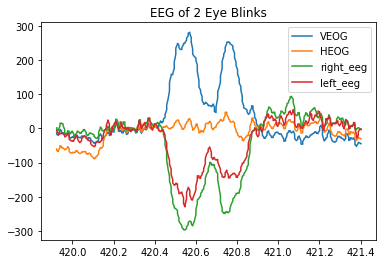

/Users/glchau/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


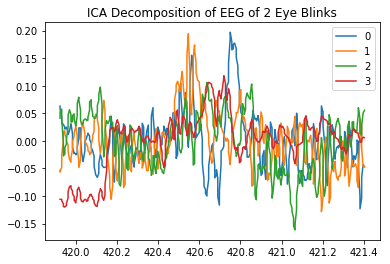

In [30]:
# Check EEG
veog_eeg = blink_data[EEG_STREAM_TYPE]['data'][:,channels['VEOG']]
heog_eeg = blink_data[EEG_STREAM_TYPE]['data'][:,channels['HEOG']]
left_eeg = blink_data[EEG_STREAM_TYPE]['data'][:,channels['left_eeg']]
right_eeg = blink_data[EEG_STREAM_TYPE]['data'][:,channels['right_eeg']]
active_eeg = blink_data[EEG_STREAM_TYPE]['data'][:,list(channels.values())]
eeg_time = blink_data[EEG_STREAM_TYPE]['time']


# EEG eye blink data
line_objects = plt.plot(eeg_time, active_eeg)
plt.legend(iter(line_objects), list(channels.keys()))
plt.title("EEG of 2 Eye Blinks")
plt.show()

ica = FastICA(n_components=4)
standardized=active_eeg
standardized /= active_eeg.std(axis=0)
S = ica.fit_transform(active_eeg)  # Reconstruct signals
A = ica.mixing_
line_objects = plt.plot(eeg_time, S)
plt.legend(iter(line_objects), list(range(len(line_objects))))
plt.title("ICA Decomposition of EEG of 2 Eye Blinks")
plt.show()

In [31]:
remove_indices = [3]  # pretend the user selected components 0, 1, and 3

# "remove" unwanted components by setting them to 0 - simplistic but gets the job done
S[:, remove_indices] = 0

#reconstruct signal
X_restored = ica.inverse_transform(S)

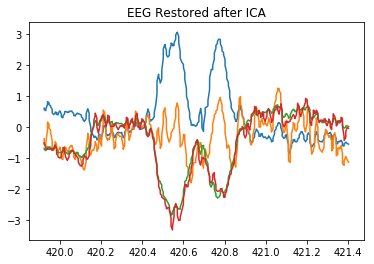

In [32]:
plt.plot(eeg_time, X_restored)
plt.title("EEG Restored after ICA")
plt.show()

### ICA of blink data (using functions + only on blink data)

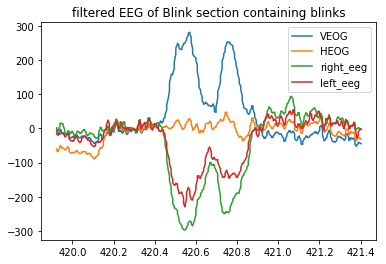

/Users/glchau/anaconda3/envs/mne/lib/python3.6/site-packages/neurodsp/filt/filter.py:86: UserWarning: Edge artifacts are not removed when using an IIR filter.
  warn('Edge artifacts are not removed when using an IIR filter.')
/Users/glchau/anaconda3/envs/mne/lib/python3.6/site-packages/neurodsp/filt/iir.py:136: UserWarning: IIR filters are not recommended other than for notch filters.
  warn('IIR filters are not recommended other than for notch filters.')
/Users/glchau/anaconda3/envs/mne/lib/python3.6/site-packages/neurodsp/filt/utils.py:65: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))
/Users/glchau/anaconda3/envs/mne/lib/python3.6/site-packages/neurodsp/filt/checks.py:144: UserWarning: Transition bandwidth is  8.0  Hz. This is greater than the desiredpass/stop bandwidth of  4.0 Hz
  'pass/stop bandwidth of  {:.1f} Hz'.format(transition_bw, pass_bw))
/Users/glchau/anaconda3/envs/mne/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: Fut

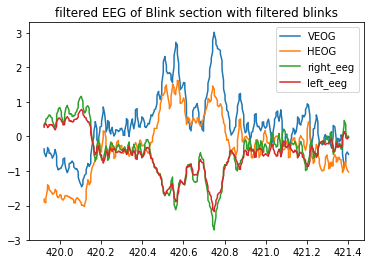

In [33]:
# Filter only the blink data
new_data, a, b = getMarkerBoundSingleMarkerData(blinkText, "--SpacePressed", original_data=filtered_data)
blink_data=new_data[0]

# Show original blink data
line_objects = plt.plot(blink_data[StreamType.EEG.value][StreamType.TIME.value], blink_data[StreamType.EEG.value][StreamType.DATA.value][:,list(channels.values())])
plt.legend(iter(line_objects), list(channels.keys()))
plt.title("filtered EEG of Blink section containing blinks")
plt.show()

# Filter out the blink component
filtered_cleaned_blink_data  = getCleanedSignal(blink_data, verbose=False)

# Show the data without the blink component
plt.plot(filtered_cleaned_blink_data[StreamType.EEG.value][StreamType.TIME.value], filtered_cleaned_blink_data[StreamType.EEG.value][StreamType.DATA.value][:,list(channels.values())])
plt.legend(iter(line_objects), list(channels.keys()))
plt.title("filtered EEG of Blink section with filtered blinks")
plt.show()

### ICA on all EEG

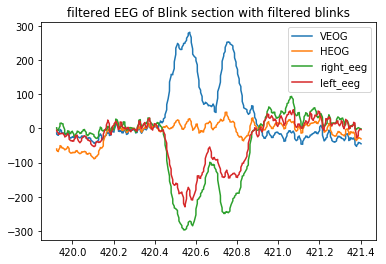

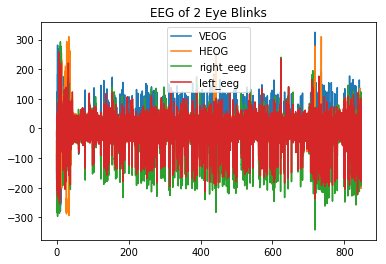

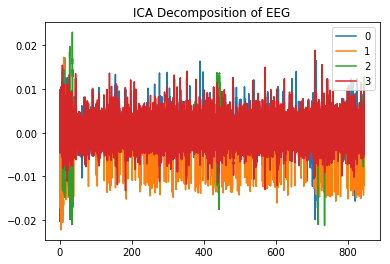

/Users/glchau/anaconda3/envs/mne/lib/python3.6/site-packages/neurodsp/filt/filter.py:86: UserWarning: Edge artifacts are not removed when using an IIR filter.
  warn('Edge artifacts are not removed when using an IIR filter.')
/Users/glchau/anaconda3/envs/mne/lib/python3.6/site-packages/neurodsp/filt/iir.py:136: UserWarning: IIR filters are not recommended other than for notch filters.
  warn('IIR filters are not recommended other than for notch filters.')
/Users/glchau/anaconda3/envs/mne/lib/python3.6/site-packages/neurodsp/filt/utils.py:65: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))
/Users/glchau/anaconda3/envs/mne/lib/python3.6/site-packages/neurodsp/filt/checks.py:144: UserWarning: Transition bandwidth is  8.0  Hz. This is greater than the desiredpass/stop bandwidth of  4.0 Hz
  'pass/stop bandwidth of  {:.1f} Hz'.format(transition_bw, pass_bw))
/Users/glchau/anaconda3/envs/mne/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: Fut

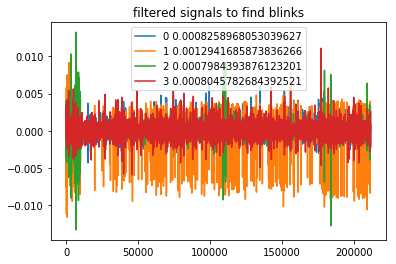

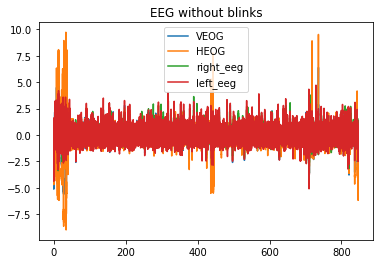

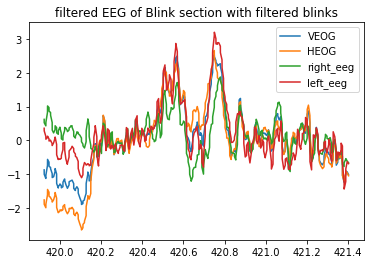

In [34]:
#Filter the entire EEG data

# Show original blink data
new_data, a, b = getMarkerBoundSingleMarkerData(blinkText, "--SpacePressed", original_data=filtered_data)
blink_data=new_data[0]

plt.plot(blink_data[StreamType.EEG.value][StreamType.TIME.value], blink_data[StreamType.EEG.value][StreamType.DATA.value][:,list(channels.values())])
plt.legend(iter(line_objects), list(channels.keys()))
plt.title("filtered EEG of Blink section with filtered blinks")
plt.show()

#Filter the entire EEG data
filtered_cleaned_data  = getCleanedSignal(filtered_data, verbose=True)


# Show the cleaned data at the blink section
new_data, a, b = getMarkerBoundSingleMarkerData(blinkText, "--SpacePressed", original_data=filtered_cleaned_data)
blink_data = new_data[0]

plt.plot(blink_data[StreamType.EEG.value][StreamType.TIME.value], blink_data[StreamType.EEG.value][StreamType.DATA.value][:,list(channels.values())])
plt.legend(iter(line_objects), list(channels.keys()))
plt.title("filtered EEG of Blink section with filtered blinks")
plt.show()


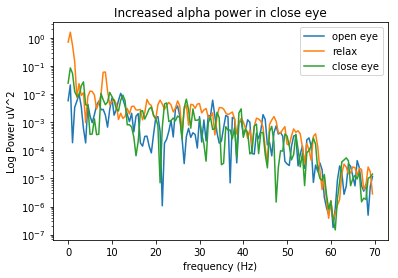

In [35]:
# Data from calibration phase
# May need to change this depending on the dataset and the available markers. 
# Older datasets may not have the start and end markers that are helpful for directly getting the section data. 
# Older datasets may also have different identifying text. 
try: 
#     data_open_eyes, index, index_sub = getMarkerBoundSingleMarkerData('--BlinkStart',  '--BlinkStop', filtered_cleaned_data, go_backward=False)
#     data_relax, index, index_sub = getMarkerBoundSingleMarkerData('--OpeneyeStart', '--OpeneyeStop',  filtered_cleaned_data, go_backward=False)
#     data_close_eyes, index, index_sub = getMarkerBoundSingleMarkerData('--CloseeyeStart', '--CloseeyeStop',  filtered_cleaned_data, go_backward=False)

# data_open_eyes, index, index_sub = getMarkerBoundSingleMarkerData('Try not to blink and count to 5\n\nthen Press Space',  '--SpacePressed', filtered_cleaned_data, go_backward=True)
#     data_relax, index, index_sub = getMarkerBoundSingleMarkerData('Close your eyes and count to 5\n\nthen Press Space', '--SpacePressed',  filtered_cleaned_data, go_backward=True)
#     data_close_eyes, index, index_sub = getMarkerBoundSingleMarkerData('Close your eyes and count to 5\n\nthen Press Space', '--SpacePressed',  filtered_cleaned_data, go_backward=True)

    
    data_open_eyes, index, index_sub = getMarkerBoundSingleMarkerData('Stare there --> <-- for 5 secs\nthen Press Space',  '--SpacePressed', filtered_cleaned_data, go_backward=True)
    data_relax, index, index_sub = getMarkerBoundSingleMarkerData('Relax for at least 5 secs\n\nthen Press Space', '--SpacePressed',  filtered_cleaned_data, go_backward=True)
    data_close_eyes, index, index_sub = getMarkerBoundSingleMarkerData('Close your eyes for 5 secs\n\nthen Press Space', '--SpacePressed',  filtered_cleaned_data, go_backward=True)

    openEyes_freqs, openEyes_psds, openEyes_psd_avg = getFreqsAndPSD(tidyEEGList(getEEGFromDataList_AvgLeftRight(data_open_eyes))) 
    relax_freqs, relax_psds, relax_psd_avg = getFreqsAndPSD(tidyEEGList(getEEGFromDataList_AvgLeftRight(data_relax))) 
    closeEyes_freqs, closeEyes_psds, closeEyes_psd_avg = getFreqsAndPSD(tidyEEGList(getEEGFromDataList_AvgLeftRight(data_close_eyes))) 

    plot_window_size = 140
    plt.semilogy(openEyes_freqs[:plot_window_size], openEyes_psd_avg[:plot_window_size], label="open eye")
    plt.semilogy(relax_freqs[:plot_window_size], relax_psd_avg[:plot_window_size], label="relax")
    plt.semilogy(closeEyes_freqs[:plot_window_size], closeEyes_psd_avg[:plot_window_size], label="close eye")
    plt.legend()
    plt.title("Increased alpha power in close eye")
    plt.ylabel("Log Power uV^2")
    plt.xlabel("frequency (Hz)")
    plt.show()

except: 
    print("Check")
    # First 20 markers 
    # Useful for identifying data from calibration phase
    print("calibration markers:\n\n",filtered_cleaned_data[StreamType.MARKER.value][StreamType.DATA.value][:20])
    raise

In [36]:
# Data from calibration phase
# May need to change this depending on the dataset and the available markers. 
# Older datasets may not have the start and end markers that are helpful for directly getting the section data. 
# Older datasets may also have different identifying text. 
if incorporate_matlab_data: 
    try: 

        data_open_eyes, index, index_sub = getMarkerBoundSingleMarkerData('--BlinkStart',  '--BlinkStop', filtered_matlab_data, go_backward=False)
        data_relax, index, index_sub = getMarkerBoundSingleMarkerData('--OpeneyeStart', '--OpeneyeStop',  filtered_matlab_data, go_backward=False)
        data_close_eyes, index, index_sub = getMarkerBoundSingleMarkerData('--CloseeyeStart', '--CloseeyeStop',  filtered_matlab_data, go_backward=False)

    #     data_open_eyes, index, index_sub = getMarkerBoundSingleMarkerData('Try not to blink and count to 5\n\nthen Press Space',  '--SpacePressed', filtered_cleaned_data, go_backward=True)
    #     data_relax, index, index_sub = getMarkerBoundSingleMarkerData('Close your eyes and count to 5\n\nthen Press Space', '--SpacePressed',  filtered_cleaned_data, go_backward=True)
    #     data_close_eyes, index, index_sub = getMarkerBoundSingleMarkerData('Close your eyes and count to 5\n\nthen Press Space', '--SpacePressed',  filtered_cleaned_data, go_backward=True)


        openEyes_freqs, openEyes_psds, openEyes_psd_avg = getFreqsAndPSD(tidyEEGList(getEEGFromDataList_AvgLeftRight(data_open_eyes))) 
        relax_freqs, relax_psds, relax_psd_avg = getFreqsAndPSD(tidyEEGList(getEEGFromDataList_AvgLeftRight(data_relax))) 
        closeEyes_freqs, closeEyes_psds, closeEyes_psd_avg = getFreqsAndPSD(tidyEEGList(getEEGFromDataList_AvgLeftRight(data_close_eyes))) 

        plot_window_size = 140
        plt.semilogy(openEyes_freqs[:plot_window_size], openEyes_psd_avg[:plot_window_size], label="open eye")
        plt.semilogy(relax_freqs[:plot_window_size], relax_psd_avg[:plot_window_size], label="relax")
        plt.semilogy(closeEyes_freqs[:plot_window_size], closeEyes_psd_avg[:plot_window_size], label="close eye")
        plt.legend()
        plt.title("Increased alpha power in close eye")
        plt.ylabel("Log Power uV^2")
        plt.xlabel("frequency (Hz)")
        plt.show()

    except: 
        print("Check")
        # First 20 markers 
        # Useful for identifying data from calibration phase
        print("calibration markers:\n\n",filtered_cleaned_data[StreamType.MARKER.value][StreamType.DATA.value][:20])
        raise

## Data Output

In [37]:
filtered_data_directory = "../data/filtered_data/"+foldername+"/"
filtered_cleaned_data_directory = "../data/filtered_cleaned_data/"+foldername+"/"

filtered_data_path = filtered_data_directory+filename+".pickle"
filtered_cleaned_data_path = filtered_cleaned_data_directory+filename+".pickle"

ensureDirExists(filtered_data_directory)
ensureDirExists(filtered_cleaned_data_directory)

writeToPickle(filtered_data, filtered_data_path)
writeToPickle(filtered_cleaned_data, filtered_cleaned_data_path)     

filename_foldername_tracker_path = "../data/most_currently_updated.pickle"
writeToPickle({"filename":filename, "foldername":foldername}, filename_foldername_tracker_path)

if incorporate_matlab_data: 
    filtered_matlab_data_directory = "../data/filtered_matlab_data/"+foldername+"/"
    filtered_matlab_data_path = filtered_matlab_data_directory+filename+".pickle"
    ensureDirExists(filtered_matlab_data_directory)
    writeToPickle(filtered_matlab_data, filtered_matlab_data_path)

print("Done!")
print(foldername, filename)


Done!
P001 part_P001_block_S006
